In [25]:
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings()
database_loc = ("./chroma_db_test6")

vectorstore = Chroma(persist_directory=database_loc,
                     embedding_function=embedding_model)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 8})

In [26]:
from langchain_ollama import OllamaLLM
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = OllamaLLM(model='llama3.2:latest')
llm2 = OllamaLLM(model='deepseek-r1:latest')
from langchain_core.prompts import PromptTemplate

template = """You are an AI assistant for the Vesuvius Challenge discord, which is a a global initiative using machine learning and computer vision to decipher the contents of the charred Herculaneum scrolls, aiming to unlock ancient knowledge without physically damaging the fragile artifacts. You will be asked questions about the challenge and will also be a provided with retrieved context from relevant discord chats. Additionally you may be asked questions about the overall sentiment of the discord chats or high level topics from the discord server. Answer the question using the provided information, which are chats from the discord server, which may contain questions, replies, etc. Use only the provided information to generate your response, do not assume or make up any details. If you do not have enough information, state "Based on the provided context, I am unable to generate a response". Stay focused only the question that follows "Question:" and give as much detail as possible. Do not summarize the context you should only be answering the question that follows "Question:". Here is your context:
{context}
Question: {question}

Answer:"""

prompt = PromptTemplate.from_template(template)

In [27]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"], k=8)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}



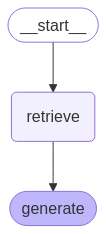

In [28]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
response = graph.invoke({"question": "Who are the experts on ink detection?"})

print(f'Answer: {response["answer"]}\n\n')
print("*" * 80)
print(f'Context: {response["context"]}\n\n')

Answer: Based on the provided context, there is no direct mention of specific individuals being referred to as "experts" on ink detection. However, it can be inferred that certain members of the Vesuvius Challenge discord server community have made significant contributions to the discussion and development of ink detection methods.

JanPaul123 seems to be a key figure in managing and organizing the competition, sharing updates, and providing resources for participants. Casey Handmer is mentioned as having written an in-depth blog post on their "crackle" method, which might be considered an expert-level approach.

Leonid Kulyk is also mentioned as having posted an exploratory data analysis notebook on Kaggle, which suggests that they have expertise in the field of ink detection and machine learning.

It's worth noting that the community seems to value diverse perspectives and approaches to ink detection, with discussions ranging from neural networks to transformers and manual "crackle"